In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE



In [33]:
# Adult veri setini doğrudan indir
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
           "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
           "hours-per-week", "native-country", "income"]

df = pd.read_csv(url, names=columns, skipinitialspace=True, na_values="?")

# Sadece sayısal sütunları al
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

Eksik değer sayısı (her sütun için):
 age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

Eksik veri oranı (yüzde):
 age               0.000000
workclass         5.638647
fnlwgt            0.000000
education         0.000000
education-num     0.000000
marital-status    0.000000
occupation        5.660146
relationship      0.000000
race              0.000000
sex               0.000000
capital-gain      0.000000
capital-loss      0.000000
hours-per-week    0.000000
native-country    1.790486
income            0.000000
dtype: float64

Eksik veri içeren ilk 5 satır:
     age workclass  fnlwgt     education  education-num         marital-status  \
14   40   Private  121772     Assoc-voc   

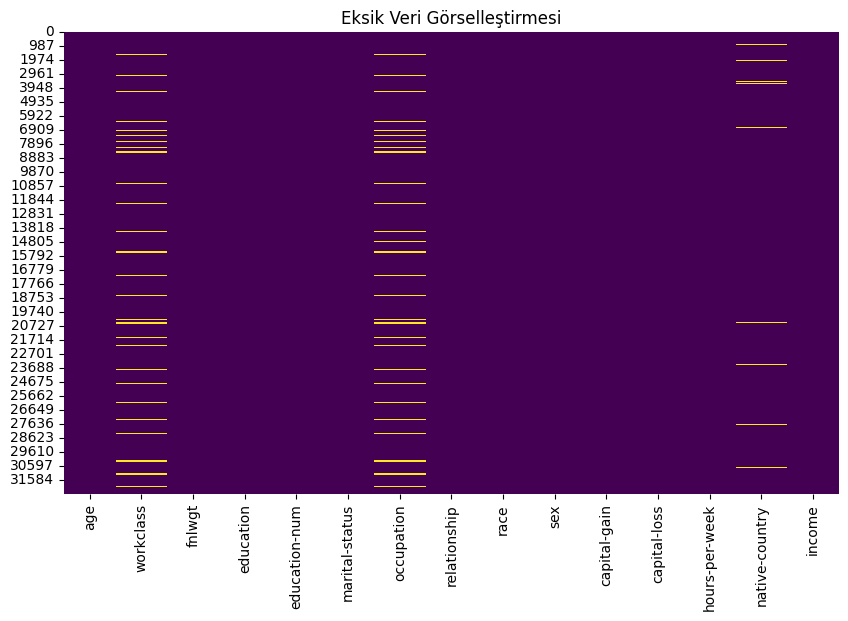

In [34]:
print("Eksik değer sayısı (her sütun için):\n", df.isnull().sum())
print("\nEksik veri oranı (yüzde):\n", (df.isnull().sum() / len(df)) * 100)

# Eksik veri içeren ilk 5 satırı göster
print("\nEksik veri içeren ilk 5 satır:\n", df[df.isnull().any(axis=1)].head())

# Eksik verileri görselleştir
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Eksik Veri Görselleştirmesi")
plt.show()

In [35]:
# Sayısal sütunlarda ortalama ile doldurma
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col] = df[col].fillna(df[col].mean())

# Kategorik sütunlarda mod ile doldurma
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna(df[col].mode()[0])

In [36]:
print("Doldurma sonrası eksik değer sayısı:\n", df.isnull().sum())

Doldurma sonrası eksik değer sayısı:
 age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


In [37]:
# Sayısal sütunları al
X = df.select_dtypes(include=['float64', 'int64'])

# LOF modelini oluştur
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')

# LOF ile aykırıları bul (-1: aykırı, 1: normal)
lof_pred = lof.fit_predict(X)
df['lof_outlier'] = (lof_pred == -1).astype(int)

# Aykırı oranı ve sayılar
lof_outlier_oran = df['lof_outlier'].mean() * 100
print(f"LOF ile aykırı oranı: %{lof_outlier_oran:.2f}")
print("Aykırı (uç) gözlem sayısı:", df['lof_outlier'].sum())
print("Normal gözlem sayısı:", (df['lof_outlier'] == 0).sum())


LOF ile aykırı oranı: %4.79
Aykırı (uç) gözlem sayısı: 1560
Normal gözlem sayısı: 31001


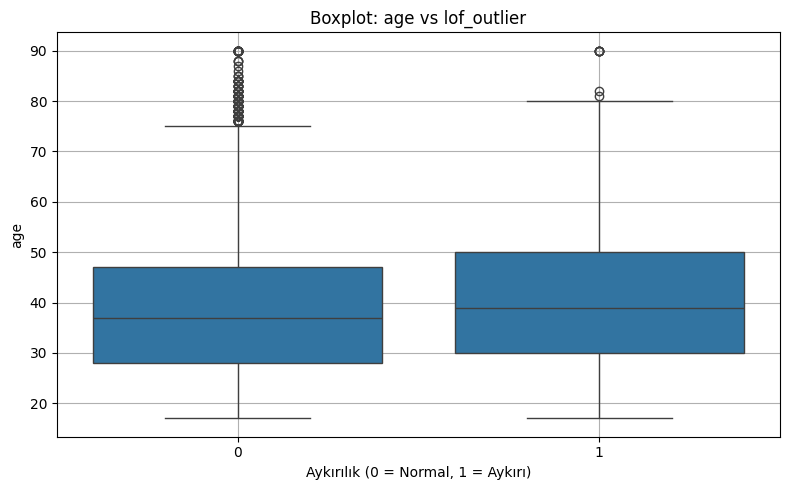

In [9]:

for col in numeric_cols[:1]:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='lof_outlier', y=col, data=df)
    plt.title(f"Boxplot: {col} vs lof_outlier")
    plt.xlabel("Aykırılık (0 = Normal, 1 = Aykırı)")
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [10]:

y = df['lof_outlier']
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

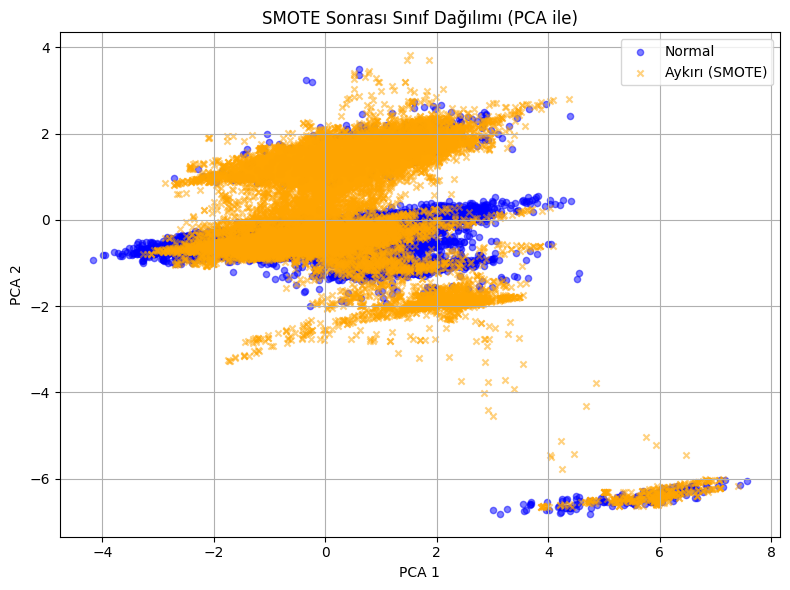

In [11]:
scaler = StandardScaler()
X_res_scaled = scaler.fit_transform(X_res)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_res_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[y_res==0, 0], X_pca[y_res==0, 1], alpha=0.5, label='Normal', c='b', s=20)
plt.scatter(X_pca[y_res==1, 0], X_pca[y_res==1, 1], alpha=0.5, label='Aykırı (SMOTE)', c='orange', s=20, marker='x')
plt.title("SMOTE Sonrası Sınıf Dağılımı (PCA ile)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

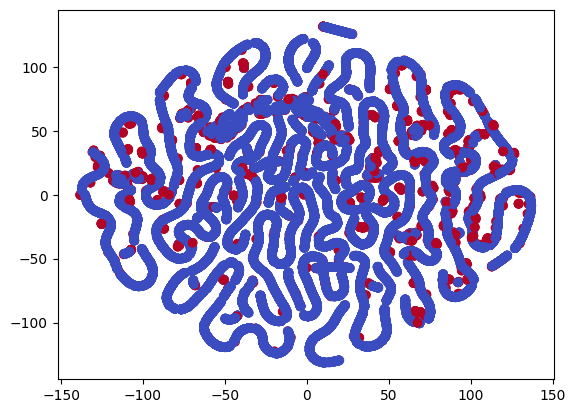

In [17]:

X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='coolwarm')


In [38]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_pred = iso_forest.fit_predict(X)

# Sonuçları DataFrame'e ekle (-1: aykırı, 1: normal)
df['iforest_outlier'] = (outlier_pred == -1).astype(int)

# Aykırı oranı ve sayısı
iforest_outlier_oran = df['iforest_outlier'].mean() * 100
print(f"Isolation Forest ile aykırı oranı: %{iforest_outlier_oran:.2f}")
print("Aykırı (uç) gözlem sayısı:", df['iforest_outlier'].sum())
print("Normal gözlem sayısı:", (df['iforest_outlier'] == 0).sum())

Isolation Forest ile aykırı oranı: %5.00
Aykırı (uç) gözlem sayısı: 1628
Normal gözlem sayısı: 30933


In [27]:


# 5) Ölçekleme
scaler = StandardScaler()
X_normal_scaled = scaler.fit_transform(X_normal)
X_all_scaled     = scaler.transform(X_all)

# 6) One-Class SVM modelini eğit
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)   # nu ≈ beklenen aykırı oranı
ocsvm.fit(X_normal_scaled)

# 7) Tüm veride tahmin
y_pred = ocsvm.predict(X_all_scaled)        # 1 = normal, –1 = aykırı
df['ocsvm_outlier'] = (y_pred == -1).astype(int)

# 8) Sonuç istatistikleri
n_out = df['ocsvm_outlier'].sum()
ratio  = df['ocsvm_outlier'].mean() * 100
print(f"One-Class SVM ile aykırı gözlem sayısı: {n_out}")
print(f"One-Class SVM ile aykırı oranı: %{ratio:.2f}")

One-Class SVM ile aykırı gözlem sayısı: 1629
One-Class SVM ile aykırı oranı: %5.00


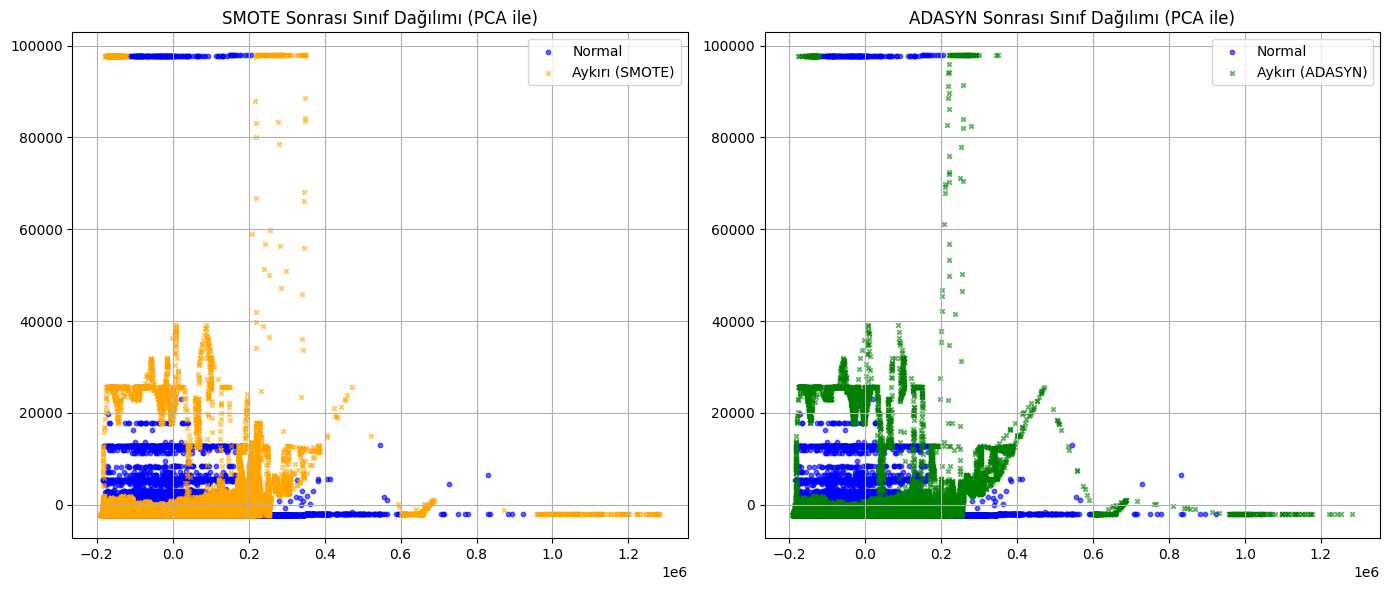

In [44]:
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Azınlık sınıf etiketleri (örnek: LOF aykırılık etiketleri)
X = df.select_dtypes(include=['float64', 'int64'])
y = df["lof_outlier"]

# 2. SMOTE ve ADASYN ile yeniden örnekleme
smote = SMOTE(random_state=42)
adasyn = ADASYN(random_state=42)

X_smote, y_smote = smote.fit_resample(X, y)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

# 3. PCA ile 2 boyuta indir
pca = PCA(n_components=2)
X_smote_pca = pca.fit_transform(X_smote)
X_adasyn_pca = pca.transform(X_adasyn)  # aynı PCA ile projekte et

# 4. Görselleştirme
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].scatter(X_smote_pca[y_smote==0, 0], X_smote_pca[y_smote==0, 1], alpha=0.6, label="Normal", c="blue", s=10)
axs[0].scatter(X_smote_pca[y_smote==1, 0], X_smote_pca[y_smote==1, 1], alpha=0.6, label="Aykırı (SMOTE)", c="orange", s=10, marker='x')
axs[0].set_title("SMOTE Sonrası Sınıf Dağılımı (PCA ile)")
axs[0].legend()
axs[0].grid(True)

axs[1].scatter(X_adasyn_pca[y_adasyn==0, 0], X_adasyn_pca[y_adasyn==0, 1], alpha=0.6, label="Normal", c="blue", s=10)
axs[1].scatter(X_adasyn_pca[y_adasyn==1, 0], X_adasyn_pca[y_adasyn==1, 1], alpha=0.6, label="Aykırı (ADASYN)", c="green", s=10, marker='x')
axs[1].set_title("ADASYN Sonrası Sınıf Dağılımı (PCA ile)")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [15]:
# Sayısal sütunları al
X = df.select_dtypes(include=['float64', 'int64'])

# LOF modelini oluştur
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')

# LOF ile aykırıları bul (-1: aykırı, 1: normal)
lof_pred = lof.fit_predict(X)
df['lof_outlier'] = (lof_pred == -1).astype(int)

# Aykırı oranı ve sayılar
lof_outlier_oran = df['lof_outlier'].mean() * 100
print(f"LOF ile aykırı oranı: %{lof_outlier_oran:.2f}")
print("Aykırı (uç) gözlem sayısı:", df['lof_outlier'].sum())
print("Normal gözlem sayısı:", (df['lof_outlier'] == 0).sum())


LOF ile aykırı oranı: %4.79
Aykırı (uç) gözlem sayısı: 1560
Normal gözlem sayısı: 31001


In [16]:
# Aykırı olarak etiketlenen ilk 10 satır
aykirilar = df[df["lof_outlier"] == 1]
print(aykirilar.head(10))


     age         workclass  fnlwgt     education  education-num  \
0     39         State-gov   77516     Bachelors             13   
2     38           Private  215646       HS-grad              9   
32    45           Private  386940     Bachelors             13   
52    47           Private   51835   Prof-school             15   
60    30           Private   59496     Bachelors             13   
68    49      Self-emp-inc  191681  Some-college             10   
106   17           Private  304873          10th              6   
112   56  Self-emp-not-inc  335605       HS-grad              9   
113   28           Private  377869  Some-college             10   
131   24           Private   43323       HS-grad              9   

         marital-status         occupation   relationship   race     sex  \
0         Never-married       Adm-clerical  Not-in-family  White    Male   
2              Divorced  Handlers-cleaners  Not-in-family  White    Male   
32             Divorced    Exec-ma

In [18]:
aykirilar = df[df["lof_outlier"] == 1]
normaller = df[df["lof_outlier"] == 0]


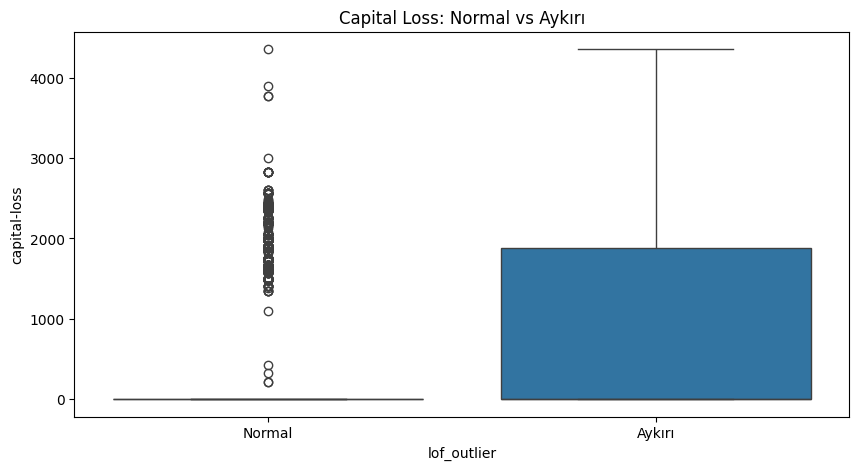

In [19]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='lof_outlier', y='capital-loss')
plt.xticks([0, 1], ['Normal', 'Aykırı'])
plt.title("Capital Loss: Normal vs Aykırı")
plt.show()

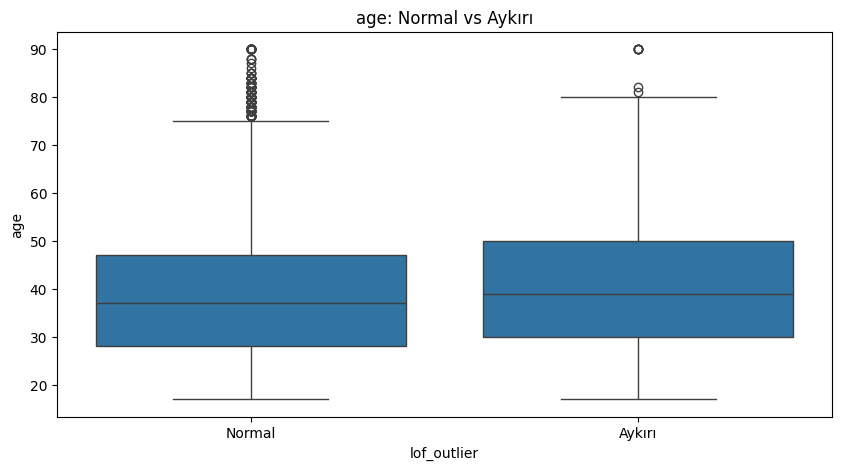

In [21]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='lof_outlier', y='age')
plt.xticks([0, 1], ['Normal', 'Aykırı'])
plt.title("age: Normal vs Aykırı")
plt.show()

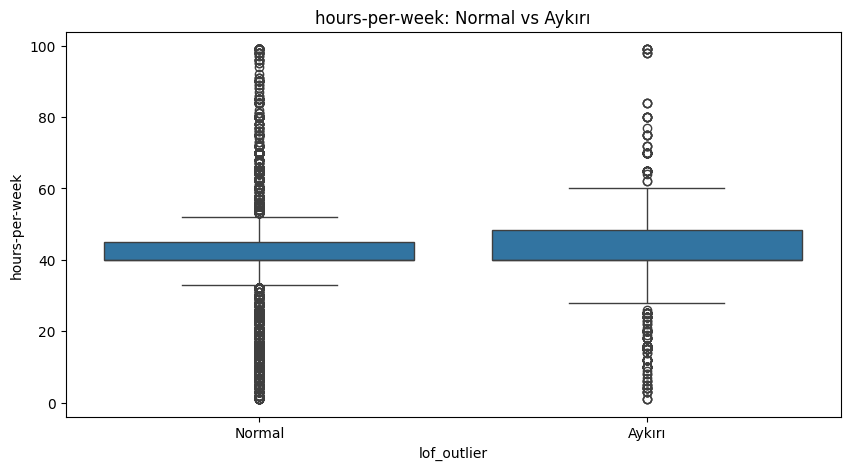

In [22]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='lof_outlier', y='hours-per-week')
plt.xticks([0, 1], ['Normal', 'Aykırı'])
plt.title("hours-per-week: Normal vs Aykırı")
plt.show()

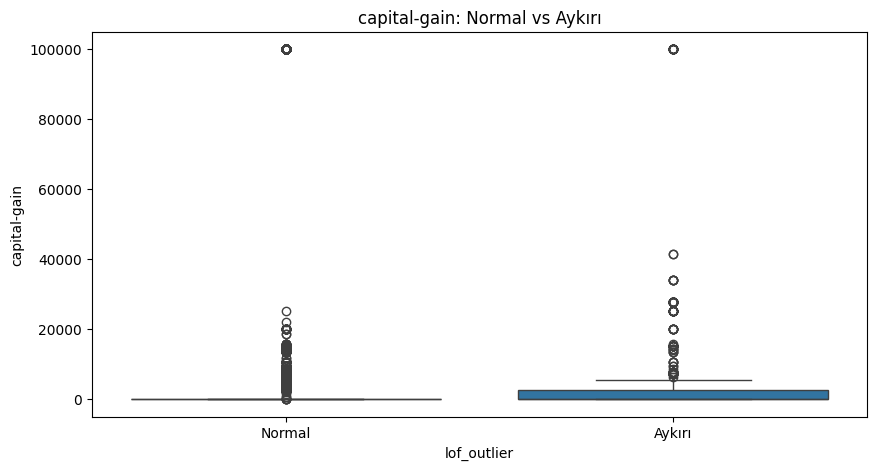

In [23]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='lof_outlier', y='capital-gain')
plt.xticks([0, 1], ['Normal', 'Aykırı'])
plt.title("capital-gain: Normal vs Aykırı")
plt.show()

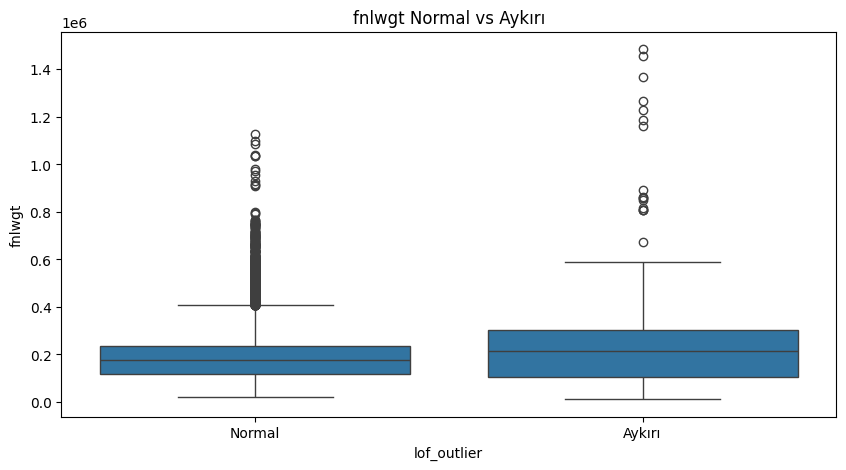

In [25]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='lof_outlier', y='fnlwgt')
plt.xticks([0, 1], ['Normal', 'Aykırı'])
plt.title("fnlwgt Normal vs Aykırı")
plt.show()

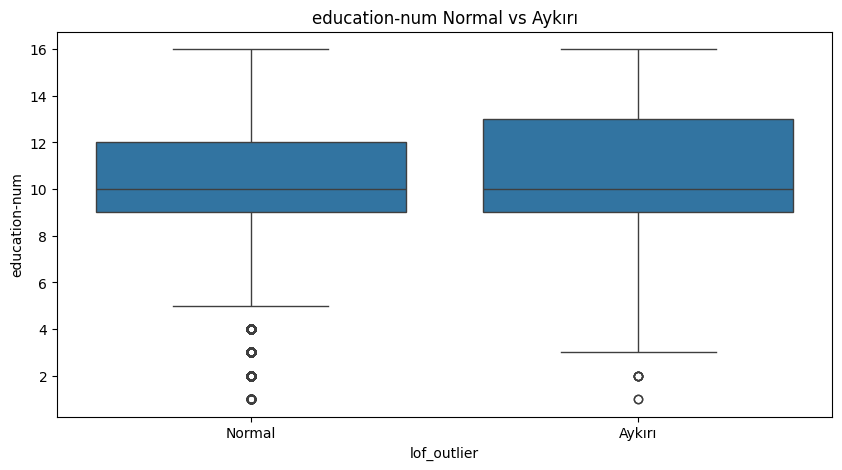

In [26]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='lof_outlier', y='education-num')
plt.xticks([0, 1], ['Normal', 'Aykırı'])
plt.title("education-num Normal vs Aykırı")
plt.show()

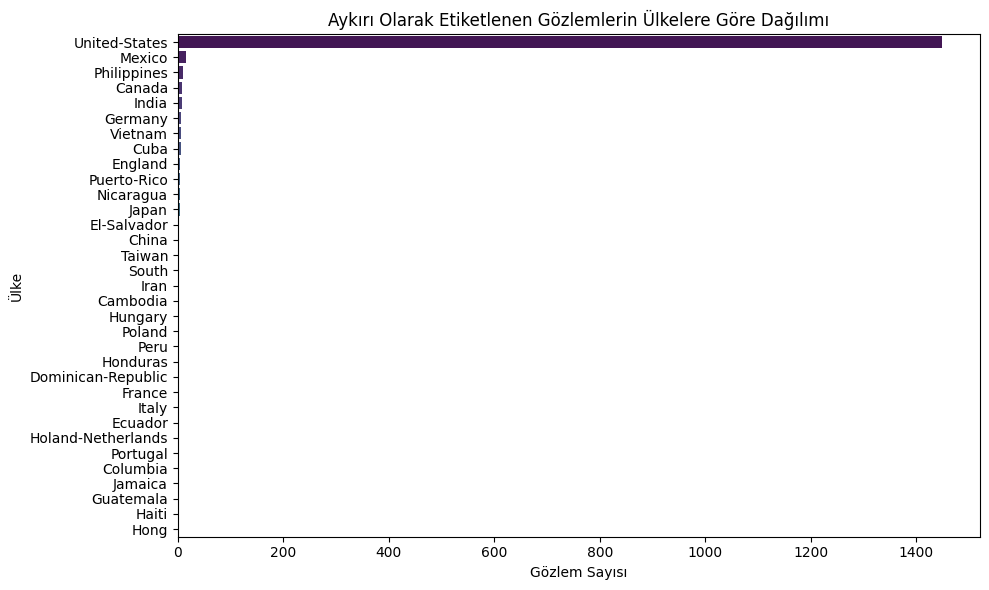

In [31]:
aykiri_ulkeler = df[df['lof_outlier'] == 1]['native-country'].value_counts().reset_index()
aykiri_ulkeler.columns = ['Ülke', 'Gözlem Sayısı']

plt.figure(figsize=(10, 6))
sns.barplot(data=aykiri_ulkeler, x='Gözlem Sayısı', y='Ülke', hue='Ülke', dodge=False, palette="viridis", legend=False)
plt.title("Aykırı Olarak Etiketlenen Gözlemlerin Ülkelere Göre Dağılımı")
plt.xlabel("Gözlem Sayısı")
plt.ylabel("Ülke")
plt.tight_layout()
plt.show()

C:\Users\guler\AppData\Local\Temp\ipykernel_16260\1846187370.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=oranlar.values[:15], y=oranlar.index[:15], palette="rocket")


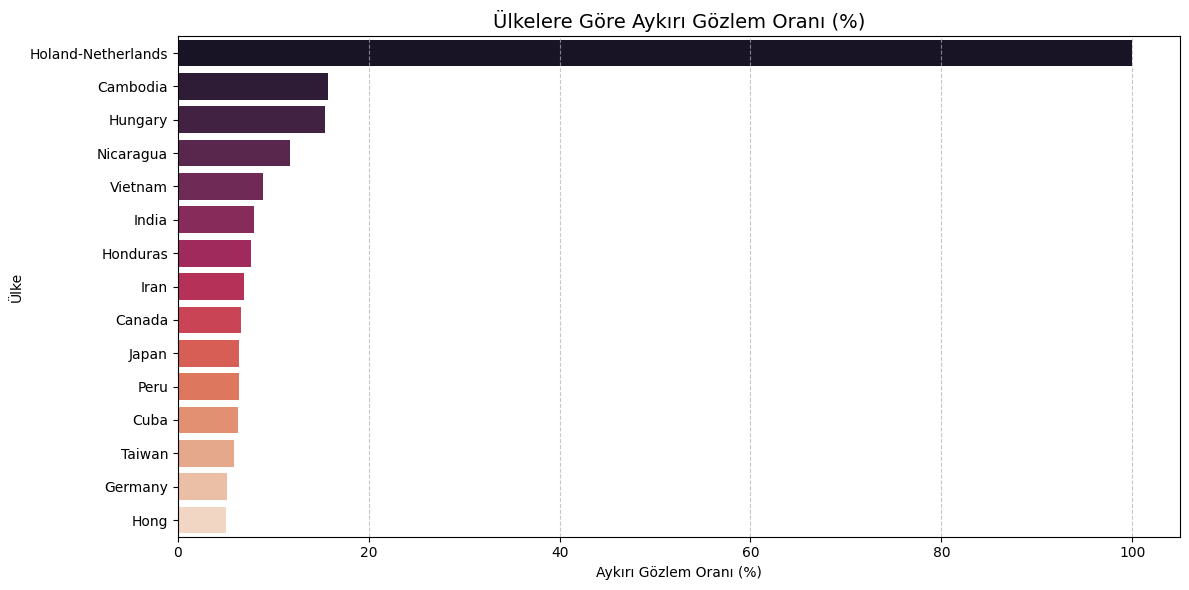

In [32]:
# Aykırı ve toplam sayıları grupla
toplam_sayilar = df['native-country'].value_counts()
aykiri_sayilar = df[df['lof_outlier'] == 1]['native-country'].value_counts()

# Yüzdelik oran hesapla
oranlar = (aykiri_sayilar / toplam_sayilar * 100).dropna().sort_values(ascending=False)

# İlk 15 ülkeyi görselleştir (isteğe göre artırılabilir)
plt.figure(figsize=(12, 6))
sns.barplot(x=oranlar.values[:15], y=oranlar.index[:15], palette="rocket")
plt.title("Ülkelere Göre Aykırı Gözlem Oranı (%)", fontsize=14)
plt.xlabel("Aykırı Gözlem Oranı (%)")
plt.ylabel("Ülke")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [34]:
# Sadece Hollanda'dan gelen gözlemleri al
hollanda_df = df[df['native-country'] == 'Holand-Netherlands'].copy()

# Aykırı ve normal olarak ayır
hollanda_aykiri = hollanda_df[hollanda_df['lof_outlier'] == 1]
hollanda_normal = hollanda_df[hollanda_df['lof_outlier'] == 0]

# 🟥 Aykırı olanları göster
print("🟥 Aykırı Olarak Etiketlenen Gözlemler:")
print(hollanda_aykiri)

# 🟩 Normal olanları göster
print("\n🟩 Normal Olarak Etiketlenen Gözlemler:")
print(hollanda_normal)

# 🟦 Görselleştirme için 'Durum' kolonu oluştur
hollanda_df['Durum'] = hollanda_df['lof_outlier'].map({0: 'Normal', 1: 'Aykırı'})



🟥 Aykırı Olarak Etiketlenen Gözlemler:
       age workclass  fnlwgt     education  education-num marital-status  \
19609   32   Private   27882  Some-college             10  Never-married   

              occupation    relationship   race     sex  capital-gain  \
19609  Machine-op-inspct  Other-relative  White  Female             0   

       capital-loss  hours-per-week      native-country income  lof_outlier  \
19609          2205              40  Holand-Netherlands  <=50K            1   

       iforest_outlier  
19609                1  

🟩 Normal Olarak Etiketlenen Gözlemler:
Empty DataFrame
Columns: [age, workclass, fnlwgt, education, education-num, marital-status, occupation, relationship, race, sex, capital-gain, capital-loss, hours-per-week, native-country, income, lof_outlier, iforest_outlier]
Index: []


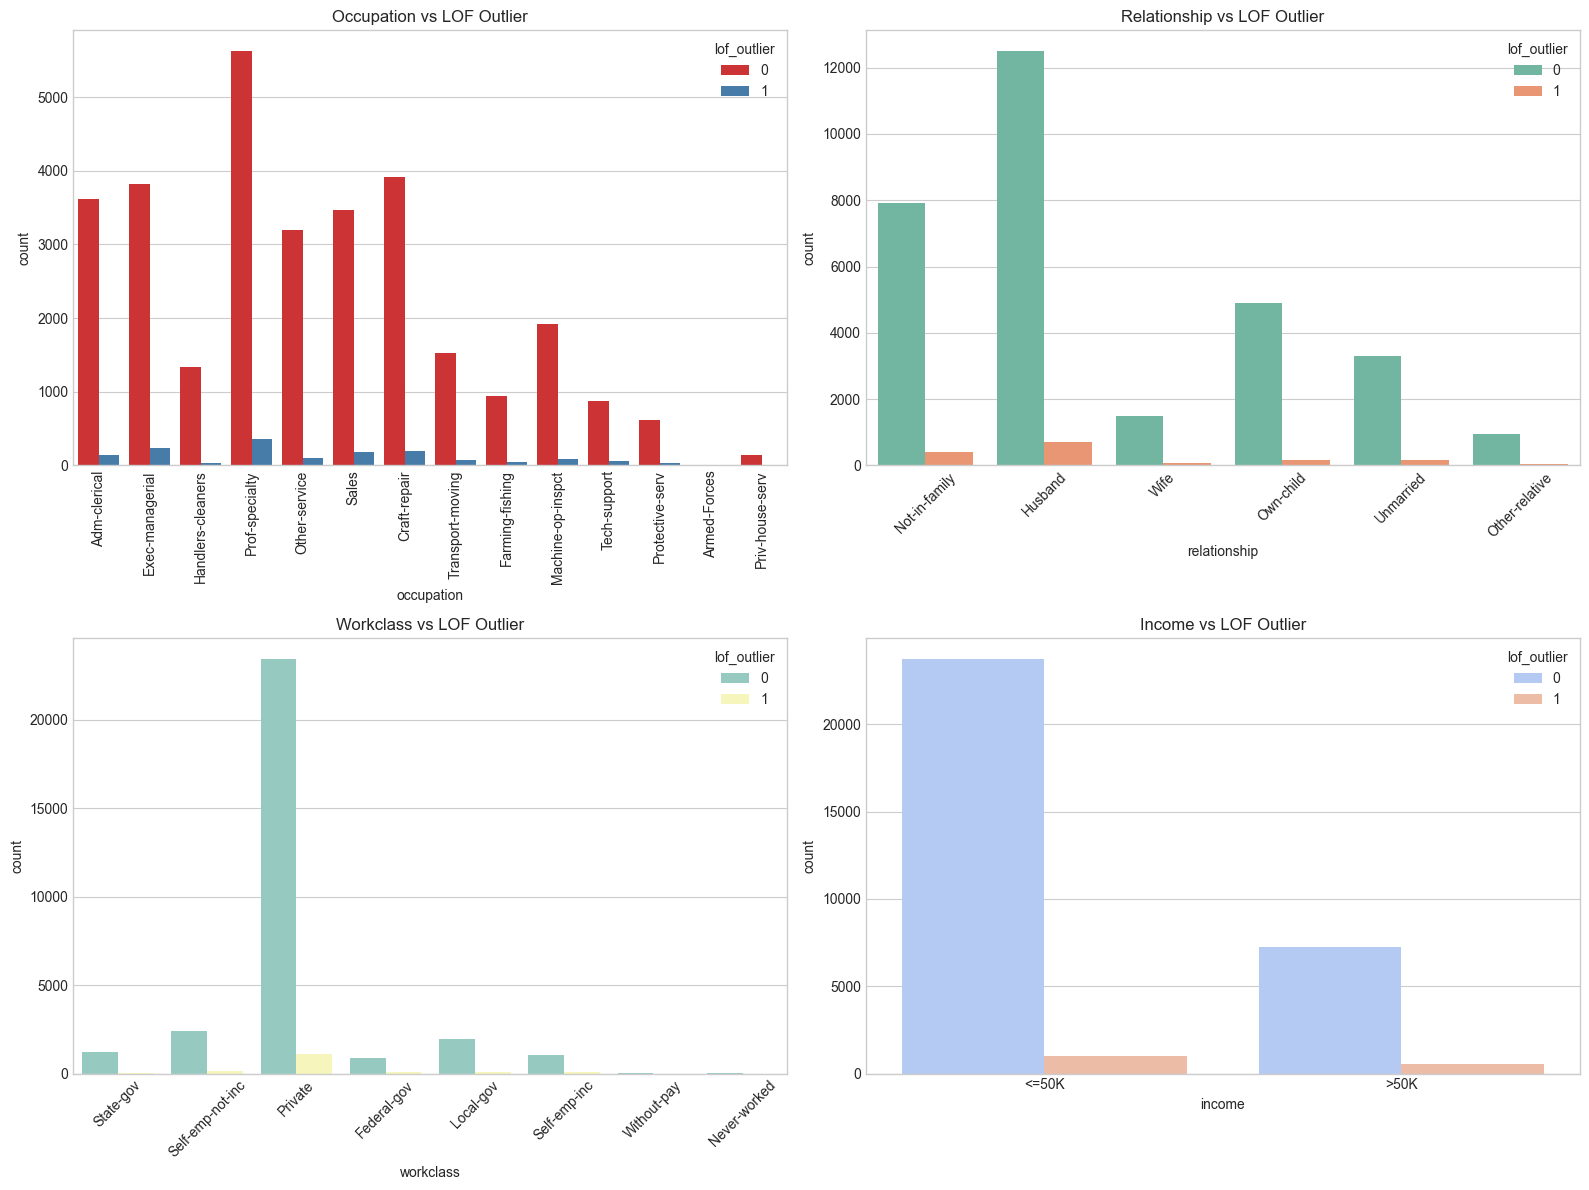

In [35]:
plt.style.use("seaborn-v0_8-whitegrid")  # Uyarı almamak için bu şekilde güncelledik

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. occupation
sns.countplot(data=df, x='occupation', hue='lof_outlier', ax=axes[0, 0], palette='Set1')
axes[0, 0].set_title("Occupation vs LOF Outlier")
axes[0, 0].tick_params(axis='x', rotation=90)

# 2. relationship
sns.countplot(data=df, x='relationship', hue='lof_outlier', ax=axes[0, 1], palette='Set2')
axes[0, 1].set_title("Relationship vs LOF Outlier")
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. workclass
sns.countplot(data=df, x='workclass', hue='lof_outlier', ax=axes[1, 0], palette='Set3')
axes[1, 0].set_title("Workclass vs LOF Outlier")
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. income
sns.countplot(data=df, x='income', hue='lof_outlier', ax=axes[1, 1], palette='coolwarm')
axes[1, 1].set_title("Income vs LOF Outlier")

plt.tight_layout()
plt.show()

In [36]:
# Aykırı (lof_outlier == 1) olarak etiketlenen gözlemler
aykiri_kategorik = df[df["lof_outlier"] == 1][["occupation", "relationship", "workclass", "income"]]

# İlk 20 tanesini göster
print(aykiri_kategorik.head(20))


            occupation   relationship         workclass income
0         Adm-clerical  Not-in-family         State-gov  <=50K
2    Handlers-cleaners  Not-in-family           Private  <=50K
32     Exec-managerial      Own-child           Private  <=50K
52      Prof-specialty           Wife           Private   >50K
60               Sales        Husband           Private  <=50K
68     Exec-managerial        Husband      Self-emp-inc   >50K
106     Prof-specialty      Own-child           Private  <=50K
112      Other-service        Husband  Self-emp-not-inc   >50K
113              Sales           Wife           Private  <=50K
131      Other-service  Not-in-family           Private  <=50K
143     Prof-specialty  Not-in-family           Private   >50K
172              Sales        Husband           Private   >50K
186    Exec-managerial  Not-in-family  Self-emp-not-inc  <=50K
200     Prof-specialty  Not-in-family           Private  <=50K
203     Prof-specialty  Not-in-family         Local-gov

In [37]:
# Belirli satırları seç
satirlar = df.loc[[52, 68, 112, 143, 172]]

# Ekrana bastır
print(satirlar)


     age         workclass  fnlwgt     education  education-num  \
52    47           Private   51835   Prof-school             15   
68    49      Self-emp-inc  191681  Some-college             10   
112   56  Self-emp-not-inc  335605       HS-grad              9   
143   45           Private  196584     Assoc-voc             11   
172   51           Private   96062  Some-college             10   

         marital-status       occupation   relationship   race     sex  \
52   Married-civ-spouse   Prof-specialty           Wife  White  Female   
68   Married-civ-spouse  Exec-managerial        Husband  White    Male   
112  Married-civ-spouse    Other-service        Husband  White    Male   
143       Never-married   Prof-specialty  Not-in-family  White  Female   
172  Married-civ-spouse            Sales        Husband  White    Male   

     capital-gain  capital-loss  hours-per-week native-country income  \
52              0          1902              60       Honduras   >50K   
68    

In [40]:
aykiri_selfempinc = df[(df['workclass'] == 'state-gov') & (df['lof_outlier'] == 1)]
print(f"Aykırı gözlem sayısı (Self-emp-inc): {len(aykiri_selfempinc)}")


Aykırı gözlem sayısı (Self-emp-inc): 0


In [41]:
# State-gov olan ve normal (lof_outlier = 0) olanları filtrele
stategov_normal = df[(df['workclass'] == 'State-gov') & (df['lof_outlier'] == 0)]

# Sonuçları yazdır
print("State-gov ve Normal (Aykırı olmayan) Gözlemler:")
print(stategov_normal)


State-gov ve Normal (Aykırı olmayan) Gözlemler:
       age  workclass  fnlwgt     education  education-num  \
11      30  State-gov  141297     Bachelors             13   
34      22  State-gov  311512  Some-college             10   
48      41  State-gov  101603     Assoc-voc             11   
123     29  State-gov  267989     Bachelors             13   
167     46  State-gov  102628       Masters             14   
...    ...        ...     ...           ...            ...   
32360   58  State-gov  200316       HS-grad              9   
32380   48  State-gov  224474  Some-college             10   
32479   64  State-gov  222966       7th-8th              4   
32540   45  State-gov  252208       HS-grad              9   
32549   43  State-gov  255835  Some-college             10   

           marital-status       occupation    relationship  \
11     Married-civ-spouse   Prof-specialty         Husband   
34     Married-civ-spouse    Other-service         Husband   
48     Married-civ-sp

In [43]:
print("34. satırın gelir sınıfı (income):", df.loc[22, 'income'])


34. satırın gelir sınıfı (income): <=50K


In [44]:
print(df.loc[68, ['age', 'workclass', 'education', 'occupation', 'hours-per-week', 'capital-gain', 'capital-loss', 'native-country', 'income']])


age                            49
workclass            Self-emp-inc
education            Some-college
occupation        Exec-managerial
hours-per-week                 50
capital-gain                    0
capital-loss                    0
native-country      United-States
income                       >50K
Name: 68, dtype: object


1. LOF (Local Outlier Factor):
Komşuluk temelli çalışır. Yani her bir gözlemin kendi komşuları ile yoğunluk karşılaştırması yapılır.

satırın, çevresindeki benzer yaş, gelir, eğitim seviyesi ve çalışma saatlerine sahip örneklerden yoğunluk açısından biraz uzak olması mümkündür.

Özellikle "Self-emp-inc" (kendi işinde çalışan) ve "capital-gain = 0" durumu, bu grupta nadir olabilir → LOF bu sapmayı aykırılık sayar.

🎯 Örnek:
Eğer çevresindeki benzer "Exec-managerial" işte olanlar genelde capital-gain > 0 ise, seninki 0 olduğu için LOF bunu aykırı görür.

2. Isolation Forest:
Karar ağaçlarıyla veri noktalarını ayırmaya çalışır.

Nokta ne kadar kolay ayrılırsa, o kadar aykırı sayılır.

satırdaki değerler (örneğin yaş=49, saat=50, gain/loss=0) dağılımda çok uçta olmayan değerler → ayrılması zor → normal kabul edilir.

🎯 Örnek:
"50 saat çalışma", "0 kazanç" gibi değerler veri kümesinde oldukça yaygın olduğu için, Isolation Forest bu noktayı kolayca ayıramaz → normal olarak etiketler.



In [45]:
print(df.loc[143, ['age', 'workclass', 'education', 'occupation', 'hours-per-week', 'capital-gain', 'capital-loss', 'native-country', 'income']])


age                           45
workclass                Private
education              Assoc-voc
occupation        Prof-specialty
hours-per-week                40
capital-gain                   0
capital-loss                1564
native-country     United-States
income                      >50K
Name: 143, dtype: object


LOF, bir noktanın komşu noktalarına göre yoğunluk farkını inceler. Yani:

Bu kişi özel sektör (Private) çalışanı.

"Prof-specialty" mesleğinde ama capital-loss değeri 1564, yani bir kayıp beyanı var.

Çevresindeki benzer profildeki bireylerin çoğu capital-loss = 0 olabilir.

Bu durumda bu birey, lokal yoğunluk açısından farklılık gösterir, yani LOF bunu "komşularına göre farklı" bulur.

🔍 Eğer civarındaki diğer "Private" + "Prof-specialty" çalışanlarda capital-loss nadir ise, bu gözlem yoğunluğu bozuyor demektir.

🔒 Neden Isolation Forest normal dedi?
Isolation Forest, bir noktayı rastgele özellikler ve eşikler kullanarak karar ağaçlarında ne kadar derinlikte ayırabildiğine bakar.

Bu satırdaki capital-loss = 1564 değeri:

Eğer veri setinde yaygınsa veya sık rastlanıyorsa, bu gözlemi ayırmak zor olur → normal sayılır.

Diğer değişkenler de (age=45, hours=40) oldukça ortalama → modelin bu kişiyi izole etmesi zor olur.



In [46]:
# 'iforest_outlier' = 1 → Aykırı (Isolation Forest)
# 'lof_outlier' = 0 → Normal (LOF)

farkli_etiketlenen = df[(df['iforest_outlier'] == 1) & (df['lof_outlier'] == 0)]
print(farkli_etiketlenen)


       age         workclass  fnlwgt     education  education-num  \
23      43           Private  117037          11th              7   
96      48  Self-emp-not-inc  191277     Doctorate             16   
126     20           Private  111697  Some-college             10   
148     64           Private  181232          11th              7   
157     71  Self-emp-not-inc  494223  Some-college             10   
...    ...               ...     ...           ...            ...   
32494   82           Private  403910       HS-grad              9   
32518   57         Local-gov  110417       HS-grad              9   
32525   81           Private  120478     Assoc-voc             11   
32531   30           Private   33811     Bachelors             13   
32539   71           Private  287372     Doctorate             16   

           marital-status        occupation   relationship  \
23     Married-civ-spouse  Transport-moving        Husband   
96     Married-civ-spouse    Prof-specialty    

In [52]:
print(df.loc[23, ['age', 'workclass', 'education', 'occupation', 'hours-per-week', 'capital-gain', 'capital-loss', 'native-country', 'income','lof_outlier','iforest_outlier']])


age                              43
workclass                   Private
education                      11th
occupation         Transport-moving
hours-per-week                   40
capital-gain                      0
capital-loss                   2042
native-country        United-States
income                        <=50K
lof_outlier                       0
iforest_outlier                   1
Name: 23, dtype: object


Isolation Forest, her gözlemi rastgele ağaçlarla ayırarak çalışır. Aykırı değerler genelde daha kısa yolda ayrılır. Bu veri için şunlar ayırt edici olmuş olabilir:

Education = 11th: Eğitim seviyesi ortalamanın altında.

Capital-loss = 2042: Bu değer birçok gözlemde sıfır, ama burada yüksek.

Income = <=50K ve buna rağmen capital loss var → garip bir kombinasyon.

Bu nedenle, Isolation Forest bu veriyi diğerlerinden daha hızlı ayırabildiği için aykırı olarak işaretlemiş.

In [53]:
print(df.loc[96, ['age', 'workclass', 'education', 'occupation', 'hours-per-week', 'capital-gain', 'capital-loss', 'native-country', 'income','lof_outlier','iforest_outlier']])


age                              48
workclass          Self-emp-not-inc
education                 Doctorate
occupation           Prof-specialty
hours-per-week                   60
capital-gain                      0
capital-loss                   1902
native-country        United-States
income                         >50K
lof_outlier                       0
iforest_outlier                   1
Name: 96, dtype: object


LOF, bir gözlemin komşularıyla olan yoğunluk farkına bakar. Eğer bu kişinin çevresinde benzer özelliklere sahip başkaları da varsa (örneğin yüksek eğitimli, fazla çalışan, yüksek gelirli bireyler), onu normal olarak etiketler.

“Bu kişi alışılmadık olabilir ama etrafında benzerleri var” → o yüzden aykırı değil.

❗ Isolation Forest Neden "Aykırı" Dedi?
Isolation Forest, bu verinin genel dağılımda çok nadir olduğunu düşünüyor çünkü:

Doctorate eğitimi çok az sayıda kişide var.

60 saat çalışmak, normal haftalık süreden daha yüksek.

Capital-loss değeri de 1902 ile oldukça yüksek.

"Self-emp-not-inc" ile bu profilde birey sayısı genel veri içinde çok düşük olabilir.S

Yani bu kişi:

"Yüksek eğitim + serbest çalışıyor + çok çalışıyor + yüksek kayıp yaşamış" gibi kombinasyonlarıyla izole edilmeye çok uygun ve bu yüzden Isolation Forest tarafından aykırı olarak algılanıyor.

🧠 Kısaca:
Özellik	Yorum
Eğitim seviyesi (Doctorate)	Veri setinde nadir → aykırılık sinyali
Self-emp-not-inc	Bağımsız ama kurumsal değil → az rastlanan
Capital-loss 1902	Yüksek kayıp → alışılmadık
60 saat çalışma	Yüksek mesai → uçta

🔹 LOF: Bu kombinasyonun olduğu kişiler birkaç tane daha varsa → normal
🔹 Isolation Forest: Bu tür bir birey veri setinde çok nadir → aykırı

In [15]:
doctorate_olanlar = df[df['education'] == 'Doctorate']
print(doctorate_olanlar)


       age         workclass  fnlwgt  education  education-num  \
20      40           Private  193524  Doctorate             16   
63      42           Private  116632  Doctorate             16   
89      43       Federal-gov  410867  Doctorate             16   
96      48  Self-emp-not-inc  191277  Doctorate             16   
189     58         State-gov  109567  Doctorate             16   
...    ...               ...     ...        ...            ...   
32429   51         Local-gov  203334  Doctorate             16   
32469   58      Self-emp-inc  181974  Doctorate             16   
32470   50           Private  485710  Doctorate             16   
32532   34           Private  204461  Doctorate             16   
32539   71           Private  287372  Doctorate             16   

           marital-status       occupation   relationship   race     sex  \
20     Married-civ-spouse   Prof-specialty        Husband  White    Male   
63     Married-civ-spouse   Prof-specialty        Husba

In [14]:
print(df.loc[32539, ['age', 'workclass', 'education', 'occupation', 'hours-per-week', 'capital-gain', 'capital-loss', 'native-country', 'income','lof_outlier','iforest_outlier']])


age                            71
workclass                 Private
education               Doctorate
occupation         Prof-specialty
hours-per-week                 10
capital-gain                    0
capital-loss                    0
native-country      United-States
income                       >50K
lof_outlier                     0
iforest_outlier                 1
Name: 32539, dtype: object


mesela 25143 local gov da ve 50k dan düşük  lise mezunu ama 3583 de local gov sermaye kaybı var üniye gitmiş 50k dan yüksek kesinliklşe aykırı

In [18]:
print(df.loc[8392, ['age', 'workclass', 'education', 'occupation', 'hours-per-week', 'capital-gain', 'capital-loss', 'native-country', 'income','lof_outlier','iforest_outlier']])


age                              30
workclass                   Private
education                Assoc-acdm
occupation         Transport-moving
hours-per-week                   37
capital-gain                      0
capital-loss                   1485
native-country        United-States
income                         >50K
lof_outlier                       1
iforest_outlier                   0
Name: 8392, dtype: object


In [19]:
# 8392. satırın komşularını al
distances, indices = lof.kneighbors([X.iloc[8392]])

# Komşuların indekslerini ve mesafelerini yazdır
print("8392. satırın komşularının indeksleri:", indices[0])
print("Komşuların uzaklıkları:", distances[0])

# Komşu satırların verilerini bastır
print("\8392. satırın en yakın komşularının verileri:")
print(df.iloc[indices[0]])

8392. satırın komşularının indeksleri: [ 8392 28046 11384  3021  3351 17140 16205  5238  7423 12173 14753 13382
 10886  3394 32008  3542 30809 25918 16242 29208]
Komşuların uzaklıkları: [   0.          281.2312216   358.85233732  590.36005962 1107.08084619
 1167.87114015 1277.89749198 1278.1173655  1309.06531541 1419.49568509
 1432.33864711 1485.0047138  1485.02356884 1485.37099743 1485.73685422
 1485.92933883 1485.93203075 1485.96635224 1486.00201884 1486.28530236]
\8392. satırın en yakın komşularının verileri:
       age         workclass  fnlwgt     education  education-num  \
8392    30           Private   97933    Assoc-acdm             12   
28046   32           Private   97723       HS-grad              9   
11384   34           Private   98283   Prof-school             15   
3021    57           Private   98350   Prof-school             15   
3351    30           Private   96851  Some-college             10   
17140   48           Private   99096  Some-college             10   

C:\Users\guler\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


In [20]:
print(df.loc[19483, ['age', 'workclass', 'education', 'occupation', 'hours-per-week', 'capital-gain', 'capital-loss', 'native-country', 'income','lof_outlier','iforest_outlier']])


age                           53
workclass                Private
education              Bachelors
occupation          Adm-clerical
hours-per-week                40
capital-gain                   0
capital-loss                1902
native-country     United-States
income                      >50K
lof_outlier                    1
iforest_outlier                0
Name: 19483, dtype: object


In [21]:
# 19483. satırın komşularını al
distances, indices = lof.kneighbors([X.iloc[19483]])

# Komşuların indekslerini ve mesafelerini yazdır
print("8392. satırın komşularının indeksleri:", indices[0])
print("Komşuların uzaklıkları:", distances[0])

# Komşu satırların verilerini bastır
print("\8392. satırın en yakın komşularının verileri:")
print(df.iloc[indices[0]])

8392. satırın komşularının indeksleri: [19483 27164 11245   172 18858  3583 20853  3351 17771  5661   571 27829
 22765  3582 17605 25737 21663 31227   355 19380]
Komşuların uzaklıkları: [   0.          325.88341474  593.05396045  597.73489107  614.73734229
  633.26376811 1315.18325719 1394.33711849 1864.78658296 1889.3189249
 1902.00525762 1902.08885176 1902.13958478 1902.15982504 1902.16087648
 1902.1958364  1902.27363962 1902.41425562 1902.42319162 1902.65682665]
\8392. satırın en yakın komşularının verileri:
       age         workclass  fnlwgt     education  education-num  \
19483   53           Private   95469     Bachelors             13   
27164   50           Private   95435       7th-8th              4   
11245   53      Self-emp-inc   96062     Bachelors             13   
172     51           Private   96062  Some-college             10   
18858   53           Private   96062  Some-college             10   
3583    43         Local-gov   96102  Some-college             10   


C:\Users\guler\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


In [41]:
# Sayısal sütunları filtrele
numerical_cols = df.select_dtypes(include='number').columns.tolist()

# Normal ve aykırı ortalamaları hesapla
normal_avg = df[df['lof_outlier'] == 0][numerical_cols].mean()
outlier_avg = df[df['lof_outlier'] == 1][numerical_cols].mean()

# Ortalamalar ve farkları birleştir
comparison_df = pd.DataFrame({
    'Normal Ortalama': normal_avg,
    'Aykırı Ortalama': outlier_avg,
    'Fark (Aykırı - Normal)': outlier_avg - normal_avg})
print("LOF Outlier Karşılaştırması")
display(comparison_df)

LOF Outlier Karşılaştırması


,Normal Ortalama,Aykırı Ortalama,Fark (Aykırı - Normal)
age,38.447082,41.255769,2.808687
fnlwgt,188349.971001,218164.064744,29814.093743
education-num,10.058192,10.527564,0.469372
capital-gain,951.807942,3578.414103,2626.606161
capital-loss,47.518628,877.932692,830.414064
hours-per-week,40.388536,41.409615,1.021080
lof_outlier,0.000000,1.000000,1.000000
iforest_outlier,0.032386,0.400000,0.367614


In [42]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Normal ve aykırı grupların ortalamalarını hesapla
normal_avg = df[df['iforest_outlier'] == 0][numeric_cols].mean()
outlier_avg = df[df['iforest_outlier'] == 1][numeric_cols].mean()

# Ortalamalar ve farklarını birleştir
comparison_df = pd.DataFrame({
    'Normal Ort': normal_avg,
    'Aykırı Ort': outlier_avg,
    'Fark': outlier_avg - normal_avg
})
print("Isolation Forest Outlier Karşılaştırması")
display(comparison_df)

Isolation Forest Outlier Karşılaştırması


,Normal Ort,Aykırı Ort,Fark
age,38.129247,47.177518,9.048271
fnlwgt,188889.704523,206663.490172,17773.785649
education-num,10.046423,10.731572,0.685150
capital-gain,489.752077,12248.048526,11758.296449
capital-loss,32.558303,1127.502457,1094.944154
hours-per-week,40.184075,45.251843,5.067767
lof_outlier,0.030259,0.383292,0.353033
iforest_outlier,0.000000,1.000000,1.000000


In [48]:
def compare_categorical_outliers(df, method_col):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    results = []

    for col in categorical_cols:
        normal = df[df[method_col] == 0][col].value_counts(normalize=True)
        outlier = df[df[method_col] == 1][col].value_counts(normalize=True)
        all_categories = set(normal.index).union(set(outlier.index))

        for cat in all_categories:
            normal_rate = normal.get(cat, 0)
            outlier_rate = outlier.get(cat, 0)
            diff = outlier_rate - normal_rate
            results.append({
                'Sütun': col,
                'Kategori': cat,
                'Normal Oran': round(normal_rate, 3),
                'Aykırı Oran': round(outlier_rate, 3),
                'Fark (Aykırı - Normal)': round(diff, 3)
            })

    return pd.DataFrame(results)

# LOF için
lof_cat_comparison = compare_categorical_outliers(df, 'lof_outlier')
print("\n--- LOF Kategorik Karşılaştırma ---\n")
print(lof_cat_comparison)

# IForest için
iforest_cat_comparison = compare_categorical_outliers(df, 'iforest_outlier')
print("\n--- Isolation Forest Kategorik Karşılaştırma ---\n")
print(iforest_cat_comparison)


--- LOF Kategorik Karşılaştırma ---

              Sütun          Kategori  Normal Oran  Aykırı Oran  \
0         workclass      Never-worked        0.000        0.000   
1         workclass       Federal-gov        0.029        0.040   
2         workclass         State-gov        0.040        0.037   
3         workclass  Self-emp-not-inc        0.077        0.095   
4         workclass         Local-gov        0.064        0.072   
..              ...               ...          ...          ...   
96   native-country       Philippines        0.006        0.006   
97   native-country            Taiwan        0.002        0.002   
98   native-country     United-States        0.913        0.928   
99           income              >50K        0.234        0.367   
100          income             <=50K        0.766        0.633   

     Fark (Aykırı - Normal)  
0                    -0.000  
1                     0.011  
2                    -0.003  
3                     0.018  
4      

In [53]:
# Farkı 0.1'den büyük olanlar (aykırılar ile normal farkı anlamlı olanlar)
lof_high_diff = lof_cat_comparison[lof_cat_comparison['Fark (Aykırı - Normal)'].abs() > 0.2]
print("\n--- LOF: Farkı 0.1'den büyük olan kategorik değerler ---\n")
print(lof_high_diff)

iforest_high_diff = iforest_cat_comparison[iforest_cat_comparison['Fark (Aykırı - Normal)'].abs() > 0.2]
print("\n--- Isolation Forest: Farkı 0.1'den büyük olan kategorik değerler ---\n")
print(iforest_high_diff)



--- LOF: Farkı 0.1'den büyük olan kategorik değerler ---

Empty DataFrame
Columns: [Sütun, Kategori, Normal Oran, Aykırı Oran, Fark (Aykırı - Normal)]
Index: []

--- Isolation Forest: Farkı 0.1'den büyük olan kategorik değerler ---

      Sütun Kategori  Normal Oran  Aykırı Oran  Fark (Aykırı - Normal)
99   income     >50K        0.224        0.559                   0.335
100  income    <=50K        0.776        0.441                  -0.335


In [55]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)  # X: sayısal sütunlar

df['tsne_1'] = X_tsne[:, 0]
df['tsne_2'] = X_tsne[:, 1]


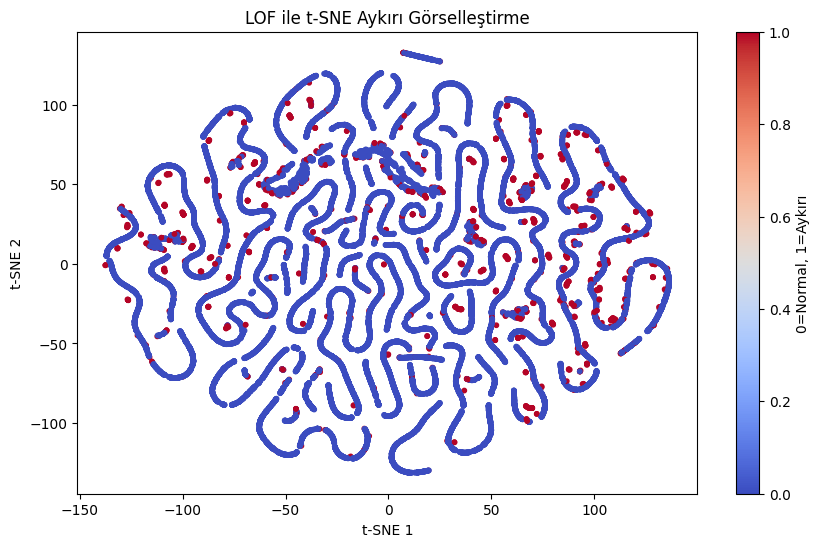

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df['tsne_1'], df['tsne_2'], c=df['lof_outlier'], cmap='coolwarm', s=10)
plt.title("LOF ile t-SNE Aykırı Görselleştirme")
plt.colorbar(label="0=Normal, 1=Aykırı")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


In [57]:
# t-SNE merkez noktası (ortalama)
center = df[['tsne_1', 'tsne_2']].mean()

# Her noktanın merkezden uzaklığı
df['tsne_dist'] = ((df['tsne_1'] - center[0])**2 + (df['tsne_2'] - center[1])**2)**0.5

# En uzak 10 örneği getir
uzaklar = df.sort_values(by='tsne_dist', ascending=False).head(10)
print(uzaklar[['tsne_1', 'tsne_2', 'tsne_dist', 'lof_outlier', 'iforest_outlier']])


           tsne_1    tsne_2   tsne_dist  lof_outlier  iforest_outlier
22293 -137.473282 -0.915428  137.467026            1                1
19609 -137.473328 -0.789876  137.466660            1                1
13436 -137.464340 -0.806118  137.457718            1                1
27113 -136.981750  5.492101  137.101059            0                0
12739 -136.977036  5.497622  137.096588            0                0
253   -136.974945  5.518589  137.095413            0                0
30579 -136.983185  5.306283  137.094650            0                0
3216  -136.972382  5.533903  137.093506            0                0
11675 -136.980164  5.349419  137.093430            0                0
18205 -136.979858  5.349751  137.093140            0                0


C:\Users\guler\AppData\Local\Temp\ipykernel_25488\197698801.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['tsne_dist'] = ((df['tsne_1'] - center[0])**2 + (df['tsne_2'] - center[1])**2)**0.5


In [59]:
print(df.loc[22293, ['age', 'workclass', 'education', 'occupation', 'hours-per-week', 'capital-gain', 'capital-loss', 'native-country', 'income','lof_outlier','iforest_outlier']])


age                              45
workclass          Self-emp-not-inc
education                 Bachelors
occupation          Farming-fishing
hours-per-week                   70
capital-gain                      0
capital-loss                   1485
native-country        United-States
income                         >50K
lof_outlier                       1
iforest_outlier                   1
Name: 22293, dtype: object


In [61]:
print(df.loc[19609, ['age', 'workclass', 'education', 'occupation', 'hours-per-week', 'capital-gain', 'capital-loss', 'native-country', 'income','lof_outlier','iforest_outlier']])


age                                32
workclass                     Private
education                Some-college
occupation          Machine-op-inspct
hours-per-week                     40
capital-gain                        0
capital-loss                     2205
native-country     Holand-Netherlands
income                          <=50K
lof_outlier                         1
iforest_outlier                     1
Name: 19609, dtype: object


In [63]:
print(df.loc[253, ['age', 'workclass', 'education', 'occupation', 'hours-per-week', 'capital-gain', 'capital-loss', 'native-country', 'income','lof_outlier','iforest_outlier']])


age                           19
workclass              Local-gov
education           Some-college
occupation          Adm-clerical
hours-per-week                40
capital-gain                   0
capital-loss                   0
native-country     United-States
income                     <=50K
lof_outlier                    0
iforest_outlier                0
Name: 253, dtype: object
